# Food Scoring based on Semantic Image Segmentation


## Setup
This notebook provides the segmentation/classification model, the Nutrition5k test set, as well as some realistic data collected by our team members (and team members' friends/families) throughout the day.

*   `data_real` contains our own collected data
*   `nutrition5k` contains the Nutrition5k dataset test split




In [47]:
# imports

import csv
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import tarfile
import os
import pandas as pd
import matplotlib.patches as mpatches
from PIL import Image
import requests
import torch
from transformers import DPTForDepthEstimation, DPTFeatureExtractor
from tqdm import tqdm

In [53]:
def computeVolume(filename):
    # # Check if filename is passed
    # if len(sys.argv) < 2:
    #     print("Please provide a filename as a command line argument.")
    #     return

    # print("Filename:", filename)

    # Rest of your function using filename

    model_filename = '/content/mobile-food-segmenter.tar.gz'
    extracted_folder_path = 'extracted_model'

    if not os.path.exists(extracted_folder_path):
        with tarfile.open(model_filename, 'r:gz') as tar:
            tar.extractall(path=extracted_folder_path)
        print("Model extracted")

    # Load the image
    image_path = filename
    image = tf.image.decode_image(tf.io.read_file(image_path))
    image = tf.image.resize(image, [513, 513])
    image = image / 255.0  # Normalize to [0, 1]
    print("Image loaded")

    # Check if the image is 3-channel RGB
    if image.shape[-1] != 3:
        print("Make sure your image is RGB.")

    # Expand dimensions for batch
    image_batch = tf.expand_dims(image, 0)

    # Load the local model with specified output keys
    m = hub.KerasLayer(extracted_folder_path, signature_outputs_as_dict=True)
    print("Model loaded")

    # Use the model
    results = m(image_batch)
    print("Model used")

    segmentation_probs = results['food_group_segmenter:semantic_probabilities'][0]
    segmentation_mask = results['food_group_segmenter:semantic_predictions'][0]

    return segmentation_probs, segmentation_mask

In [44]:
def read_csv_to_dict(file_path):
    data_dict = {}
    with open(file_path, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row
        for row in csvreader:
            key, value = row
            data_dict[int(key)] = value.split('|')
    return data_dict

In [50]:
from scipy.ndimage import center_of_mass

def visualize_segmentation_mask(segmentation_mask, filename):
    # Convert to numpy array if it's a TensorFlow tensor
    if isinstance(segmentation_mask, tf.Tensor):
        segmentation_mask = segmentation_mask.numpy()

    plt.figure(figsize=(5, 5))
    plt.imshow(segmentation_mask, cmap='cubehelix')

    unique_segments = np.unique(segmentation_mask)
    for segment in unique_segments:
        # Find the center of mass for each segment
        # Note: center_of_mass returns the centroid in (y, x) format
        centroid = center_of_mass(segmentation_mask == segment)

        # Display the segment number at its centroid
        plt.text(centroid[1], centroid[0], str(segment), color='white', ha='center', va='center')

    plt.colorbar()
    plt.title(f'Segmentation Mask for {os.path.basename(filename)}')
    plt.show()


In [57]:
def get_top_k_labels(segmentation_mask, k=3):
    # Flatten the segmentation mask
    flat_mask = segmentation_mask.flatten()
    exclude_labels = [0, 23, 24, 25] # exclude background, food containers, cutlery

    # Count the occurrence of each unique label in the mask
    labels, counts = np.unique(flat_mask, return_counts=True)

    # Sort the counts in descending order
    exclusion_mask = np.isin(labels, exclude_labels, invert=True)

    labels = labels[exclusion_mask]
    counts = counts[exclusion_mask]

    sorted_indices = np.argsort(-counts)

    # Get the top three labels
    top_three_labels = labels[sorted_indices[:k]]

    return top_three_labels

coffee_1.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 28.96it/s]

Model used


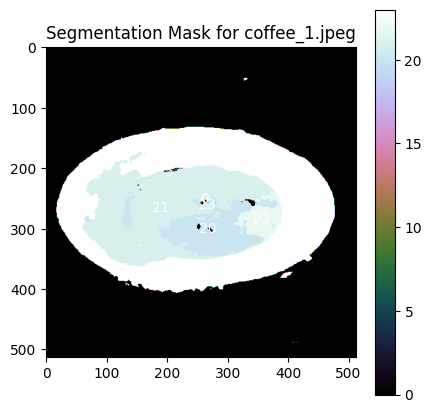

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 25.86it/s]


Top labels:
['beverages']
['sweets/desserts']
apple_banana_drink.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 28.67it/s]

Model used


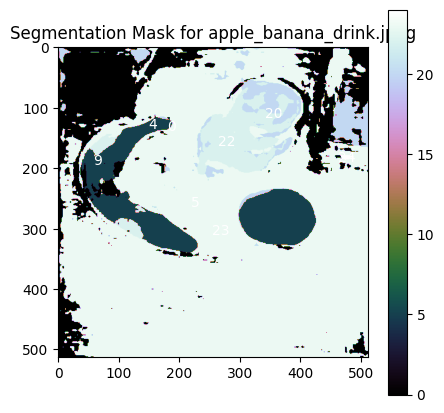

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


Top labels:
['fruits']
['fats/oils/sauces']
pasta_brokkoli_and_cherries.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:02<00:00, 35.25it/s]

Model used


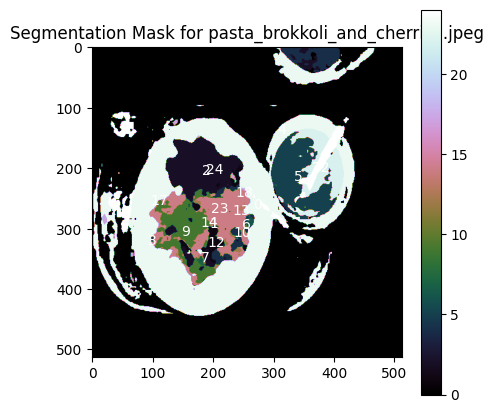

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 30.37it/s]


Top labels:
['vegetables ', ' stem_vegetables']
['starches/grains ', ' starchy_vegetables']
cookie.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:02<00:00, 36.11it/s]

Model used


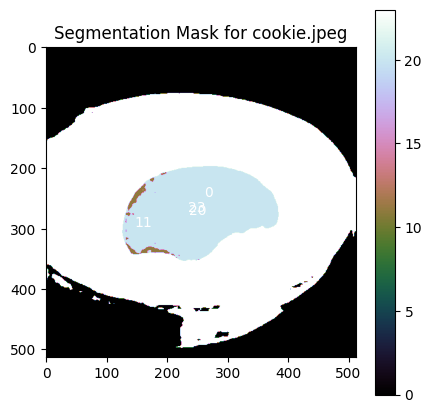

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 31.47it/s]


Top labels:
['sweets/desserts']
['starches/grains ', ' baked_goods']
coffee_2.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:04<00:00, 24.38it/s]

Model used


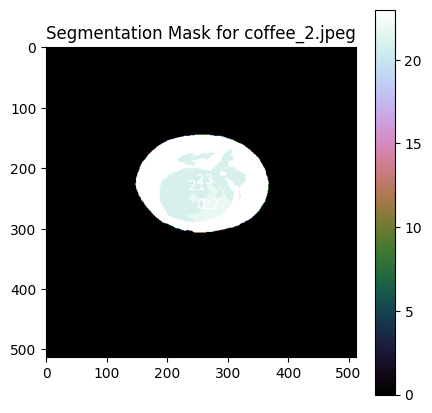

Computing Volume: 100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


Top labels:
['beverages']
['fats/oils/sauces']
tea.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:02<00:00, 35.10it/s]

Model used


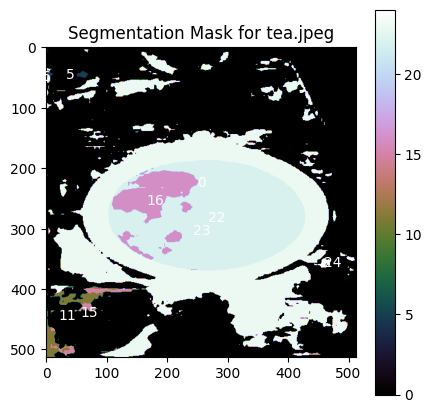

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 30.45it/s]


Top labels:
['fats/oils/sauces']
['soups/stews']
apple_2.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:02<00:00, 36.00it/s]

Model used


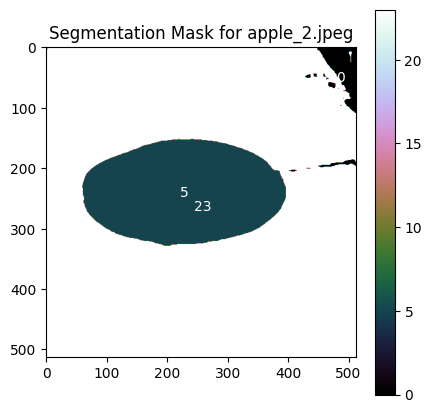

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 31.58it/s]


Top labels:
['fruits']
apple_1.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:02<00:00, 37.82it/s]

Model used


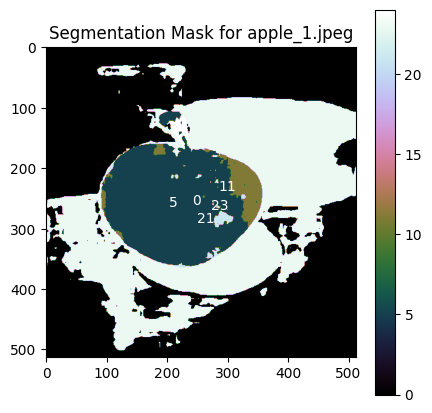

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 32.81it/s]


Top labels:
['fruits']
['starches/grains ', ' baked_goods']
banana_and_drink.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]

Model used


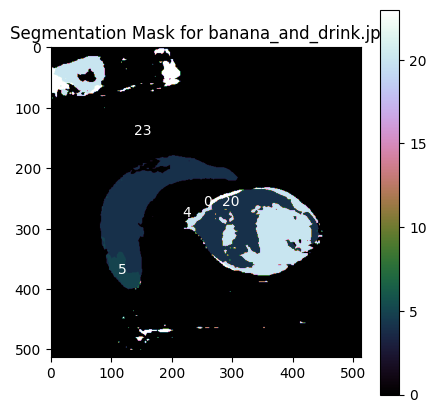

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 25.21it/s]


Top labels:
['vegetables ', ' other']
['sweets/desserts']
yoghurt.jpeg


Computing Volume:   0%|          | 0/100 [00:00<?, ?it/s]

Image loaded
Model loaded


Computing Volume: 100%|██████████| 100/100 [00:02<00:00, 34.49it/s]

Model used


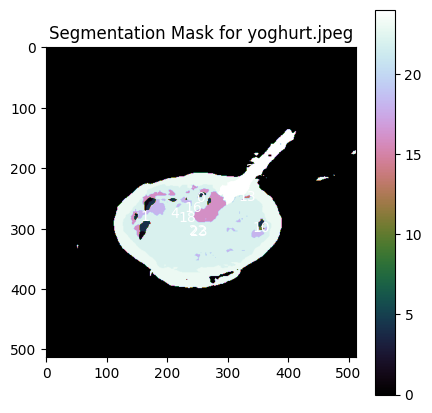

Computing Volume: 100%|██████████| 100/100 [00:03<00:00, 30.02it/s]

Top labels:
['fats/oils/sauces']
['soups/stews']


In [58]:
directory_path = '/content/data_real'

label_dict = read_csv_to_dict('/content/seefood_mobile_food_segmenter_V1_labelmap.csv')


for filename in os.listdir(directory_path):
    if os.path.isfile(os.path.join(directory_path, filename)):
      print(filename)

      with tqdm(total=100, desc="Computing Volume") as pbar:
        class_probabilities, mask = computeVolume(os.path.join(directory_path, filename))
        pbar.update(100)

        visualize_segmentation_mask(mask, filename)
        top_labels = get_top_k_labels(mask.numpy(), k=3)
        print("Top labels:")
        for top_label in top_labels:
            label_value = label_dict.get(top_label, "Label not found")  # Retrieve the value from label_dict or display a message if not found
            print(f"{label_value}")
